In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mplt
import seaborn as sns
import arviz as az
import datetime

In [2]:
import fit_arima

### TO-DOs:

- Ripristinare la posterior_predictive (commentata nel codice STAN e non aggiornata per gestire le varie stazioni)
- Ripristinare la registrazione dei dati mancanti (commentata nel codice fit_arima.py e non aggiornata per gestire le varie stazioni)

## Day Planner
Il modello attualmente considerato è il seguente:

Definita la funzione $\text{sigmoide}$:
$$
\Sigma(z) = \frac{e^z - 1}{e^z + 1}
$$

Sia $s$ l'indice che scorre le stazioni:
$$
s \in \left\{ 1,\dots, S \right\}
$$
allora:
$$
\left. \mathbf{y}_s \right| \gamma_\theta, \underline{\gamma_\phi}, \sigma, \underline{\mu_\phi}, \underline{\sigma_\phi} \sim \text{ARIMA}_{2,1,1}\left( \Sigma(\gamma_{\phi,s}[0]), \Sigma(\gamma_{\phi,s}[1]), \Sigma(\gamma_\theta) , \sigma\right)\\
\left. \gamma_{\phi,s}[j] \right| \underline{\mu_\phi}, \underline{\sigma_\phi} \sim \mathcal{N}\left( \mu_{\phi}[j], \sigma_{\phi}[j] \right), \qquad j \in \left\{ 1,\dots,p \right\} = \left\{ 1,2 \right\}\\
\left. \gamma_\theta \right. \sim \mathcal{N}\left( 0,1 \right)\\
\left. \mu_\phi[j] \right. \sim \mathcal{N}\left( 0,5 \right) \qquad j \in \left\{ 1,\dots,p \right\}\\
\left. \sigma_\phi[j] \right. \sim \mathcal{IG}\left( 2.1,1.1 \right) \qquad j \in \left\{ 1,\dots,p \right\}
$$

L'ARIMA utilizza anche dati precedenti al giorno iniziale trattati come dati mancanti.
I dati mancanti in generale hanno bisogno di prior, che sono state scelte come segue:
$$
y[missing] \sim \mathcal{N}\left( 1,1 \right)
$$
(nel codice STAN sono la variabile 'w')

Tuttavia i dati precedenti i giorni iniziali sono stati trattati diversamente, secondo il modello:
$$
y_{start} | \mu_{start}, \sigma_{start} \sim \mathcal{N}\left( \mu_{start}, \sigma_{start} \right)\\
\mu_{start} \sim \mathcal{N}\left( 1,1 \right)\\
\sigma_{start} \sim \mathcal{IG}\left( 3,2 \right)
$$

Naturalmente se scrivessimo le cose per bene, la likelihood dell'ARIMA dovrebbe essere condizionata anche ai dati mancanti

In [3]:
import open_data
df_temp = open_data.open()
df = df_temp[0]

Nel mio PC (br1) la porzione STAN del codice che segue è stata eseguita in ~ 26 minuti (da notare che prima di inserire le "hyper prior" che rendono il modello gerarchico, si ottenevano tempistiche di ~ 60 minuti)

(Sarebbe bello eseguire tutti il codice correggendo opportunamente in funzione dei core e segnare quanto ci vuole, quindi ad esempio con 4 core inserire catene=4 e samples_per_chain=1000, 6 core catene=6, samples = 750, il tempo da registrare sarebbe quello che appare a destra della barra di caricamento quando STAN termina la computazione)

In [4]:
ritorno = fit_arima.compute(2, 1, catene=4, samples_per_chain=500, burnin=500)

10:37:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:13:31 - cmdstanpy - INFO - CmdStan done processing.
11:13:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gp_exp_quad_cov: length_scale is 0, but must be positive! (in '/home/br1/PythonProjects/PythonStats/git_bayesian_copie/ARIMA_spatial/ARIMA_STAN_matrices/code.stan', line 99, column 2 to column 53)
	Exception: gp_exp_quad_cov: length_scale is 0, but must be positive! (in '/home/br1/PythonProjects/PythonStats/git_bayesian_copie/ARIMA_spatial/ARIMA_STAN_matrices/code.stan', line 99, column 2 to column 53)
	Exception: gp_exp_quad_cov: length_scale is 0, but must be positive! (in '/home/br1/PythonProjects/PythonStats/git_bayesian_copie/ARIMA_spatial/ARIMA_STAN_matrices/code.stan', line 99, column 2 to column 53)
	Exception: gp_exp_quad_cov: length_scale is 0, but must be positive! (in '/home/br1/PythonProjects/PythonStats/git_bayesian_copie/ARIMA_spatial/ARIMA_STAN_matrices/code.stan', line 99, column 2 to column 53)
	Exception: gp_exp_quad_cov: length_scale is

In [5]:
# import pickle

# # Store data (serialize)
# with open('cos_all.pickle', 'wb') as handle:
#     pickle.dump(ritorno, handle, protocol=pickle.HIGHEST_PROTOCOL)

# # Load data (deserialize)
# with open('cos_all.pickle', 'rb') as handle:
#     unserialized_data = pickle.load(handle)

# print(ritorno == unserialized_data)

In [6]:
pd.set_option('display.max_rows', 500)
az.summary(ritorno['inference_data'], var_names=['phi','theta','betas','sigma', 'hyper_gamma_phi_m', 'hyper_gamma_phi_s','y_start','c','rho','alpha','w_s'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"phi[0, 0]",0.685,0.024,0.642,0.728,0.001,0.000,1716.0,1732.0,1.00
"phi[0, 1]",0.676,0.025,0.628,0.719,0.001,0.000,1587.0,1612.0,1.00
"phi[0, 2]",0.678,0.023,0.635,0.718,0.001,0.000,2106.0,1580.0,1.00
"phi[0, 3]",0.672,0.024,0.626,0.716,0.001,0.000,1875.0,1490.0,1.00
"phi[0, 4]",0.673,0.024,0.625,0.717,0.001,0.000,2385.0,1616.0,1.00
"phi[0, 5]",0.686,0.025,0.634,0.727,0.001,0.000,2383.0,1799.0,1.00
"phi[0, 6]",0.690,0.024,0.644,0.736,0.001,0.000,2195.0,1589.0,1.00
"phi[0, 7]",0.710,0.024,0.664,0.754,0.001,0.000,1558.0,1296.0,1.00
"phi[0, 8]",0.714,0.023,0.673,0.756,0.001,0.000,1534.0,1728.0,1.00
"phi[0, 9]",0.706,0.025,0.658,0.752,0.001,0.000,1928.0,1355.0,1.00


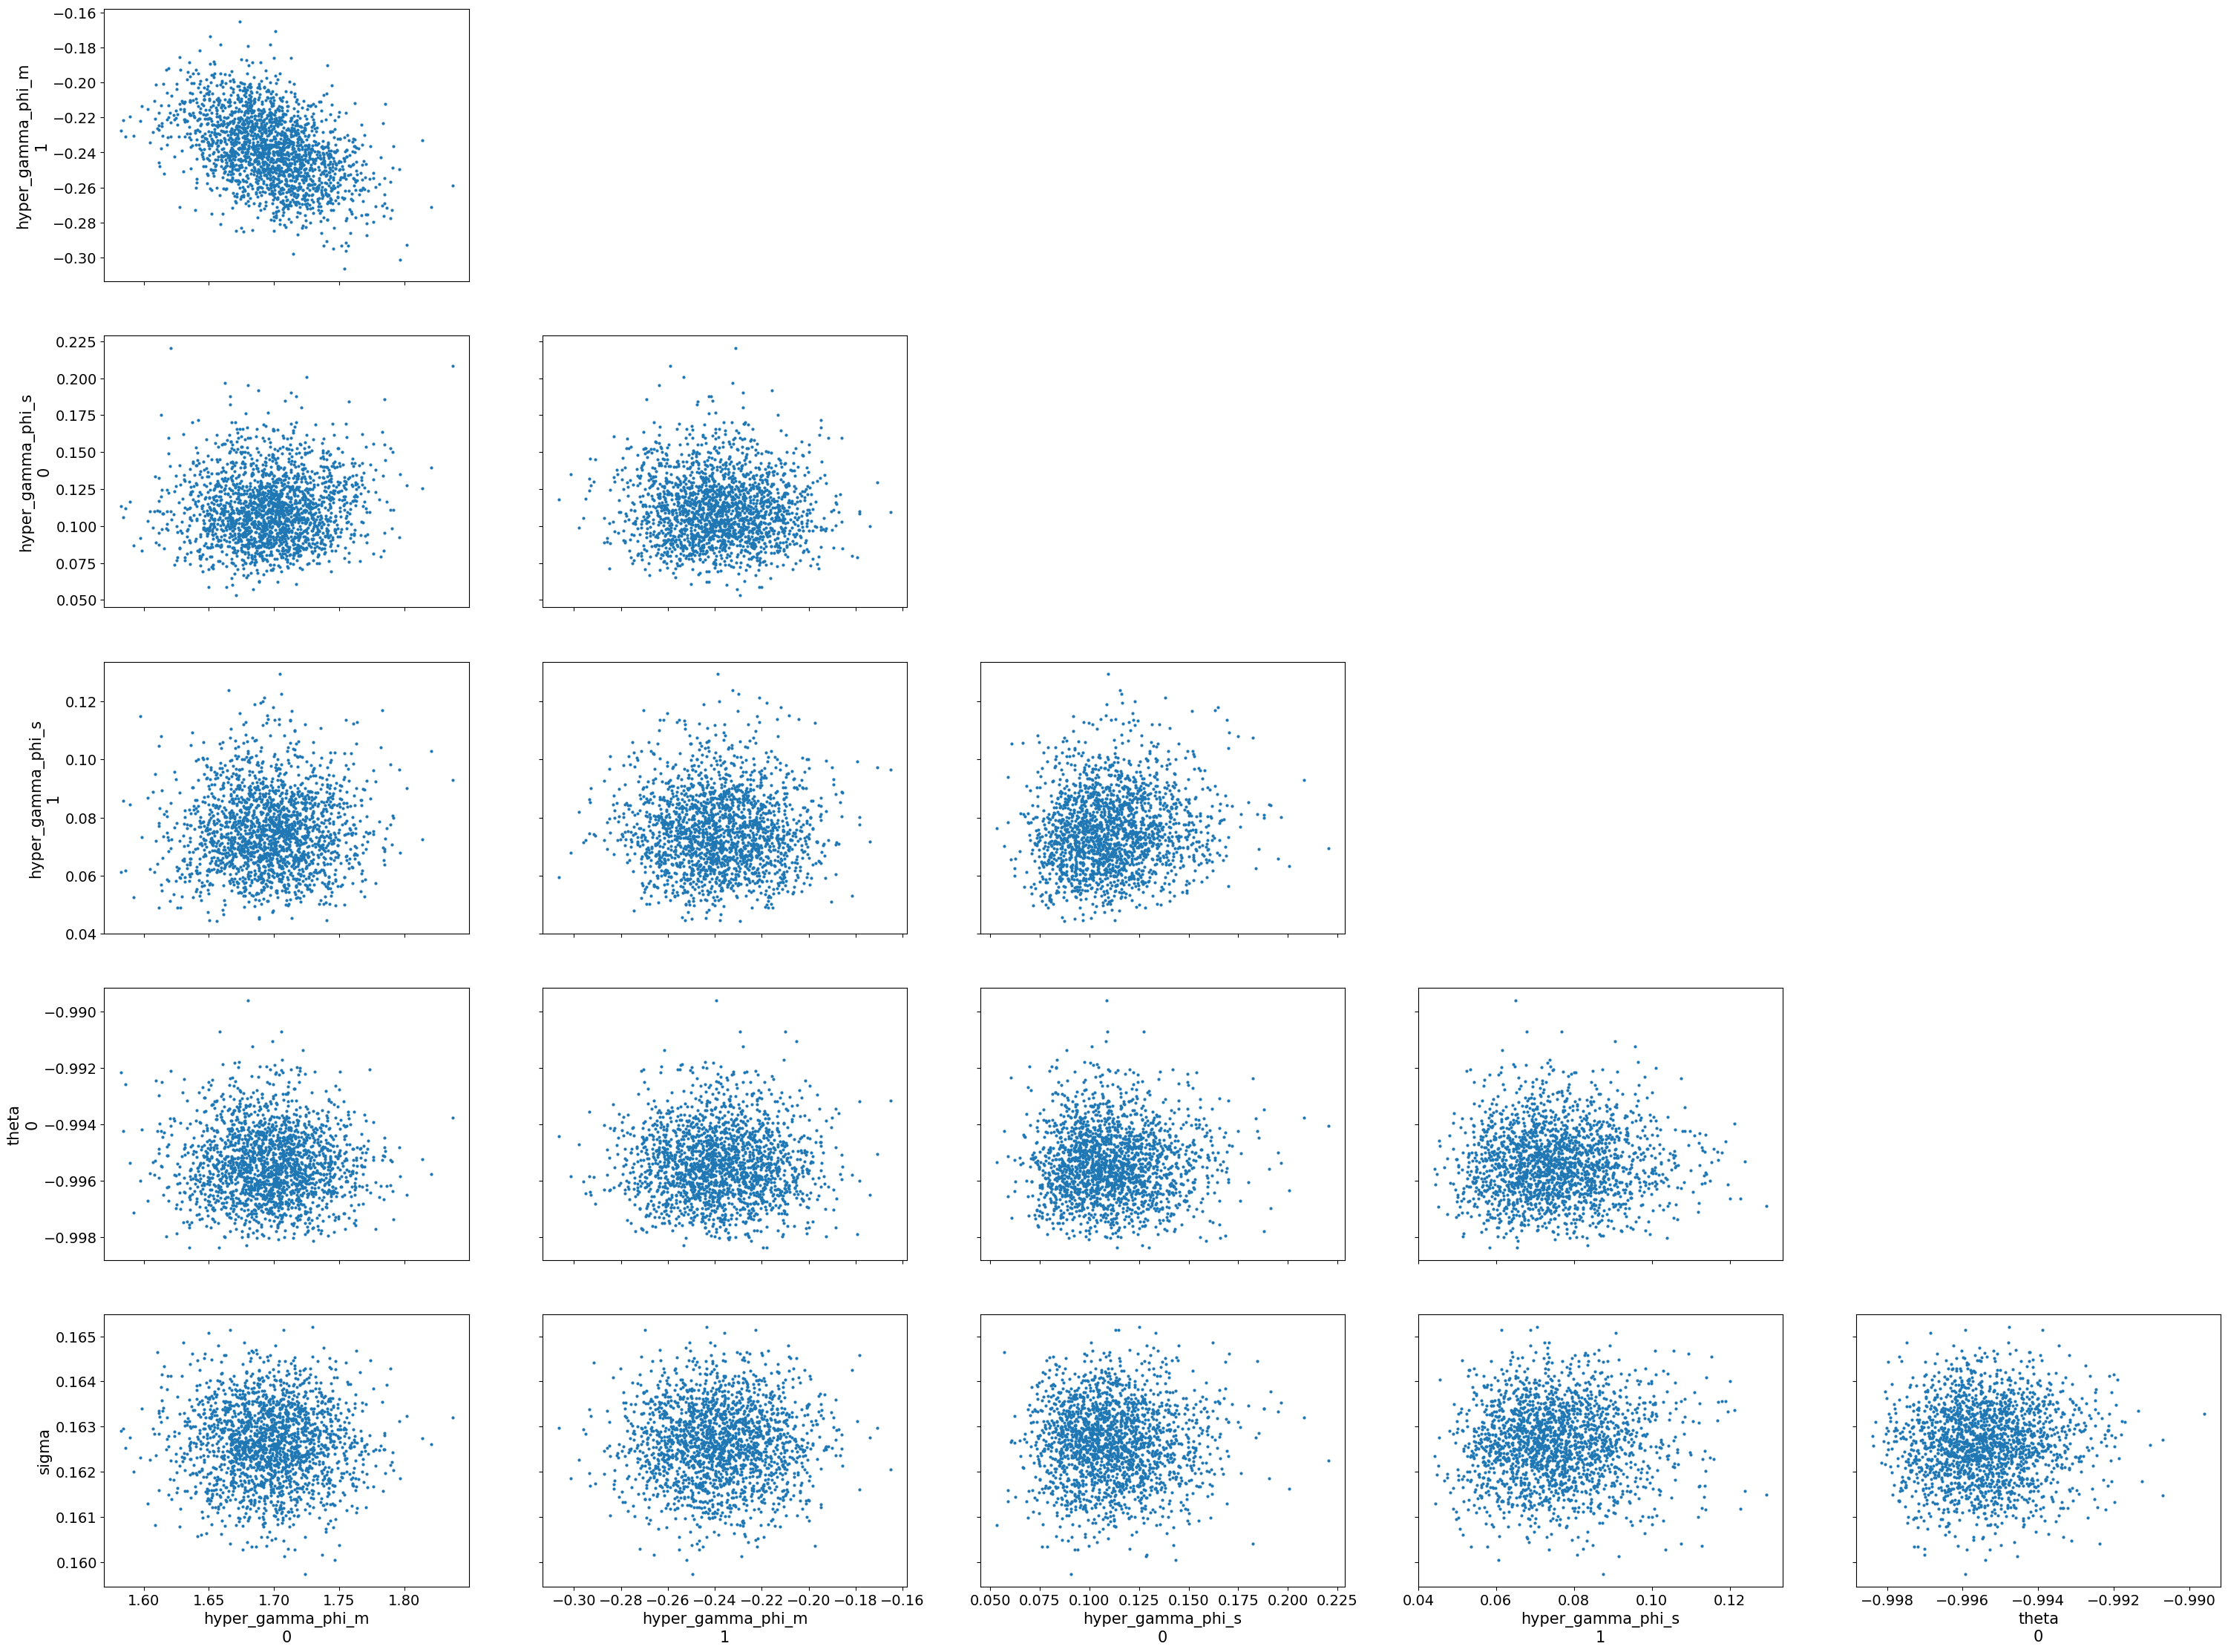

In [7]:
plt_aux = az.plot_pair(ritorno['inference_data'], var_names=['hyper_gamma_phi_m', 'hyper_gamma_phi_s', 'theta', 'sigma'], divergences=True)

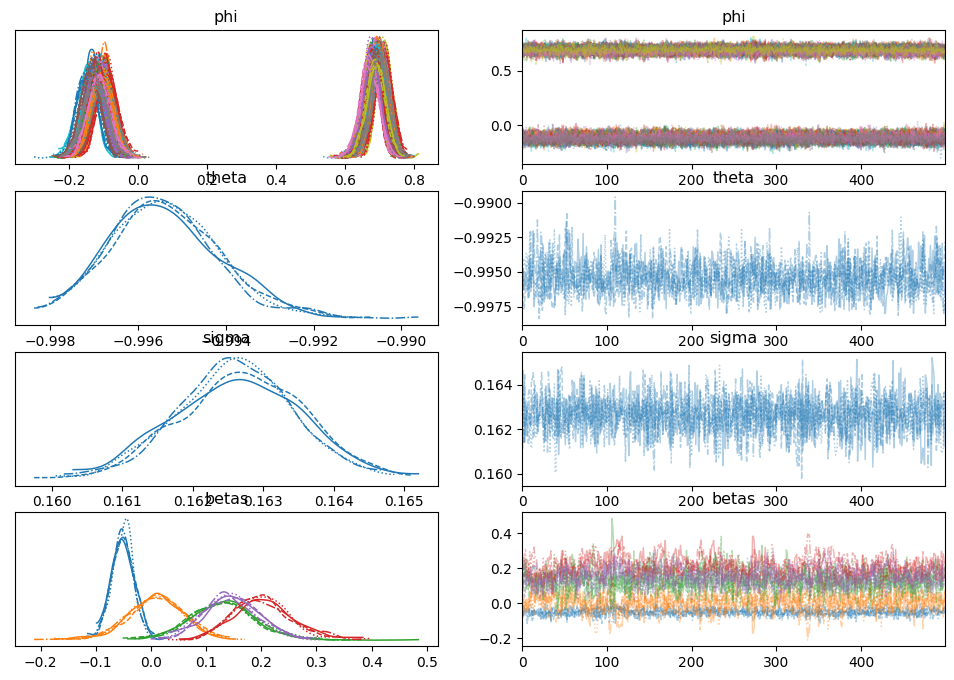

In [8]:
plt_aux = az.plot_trace(ritorno['inference_data'], var_names=['phi','theta','sigma','betas'], divergences=True)

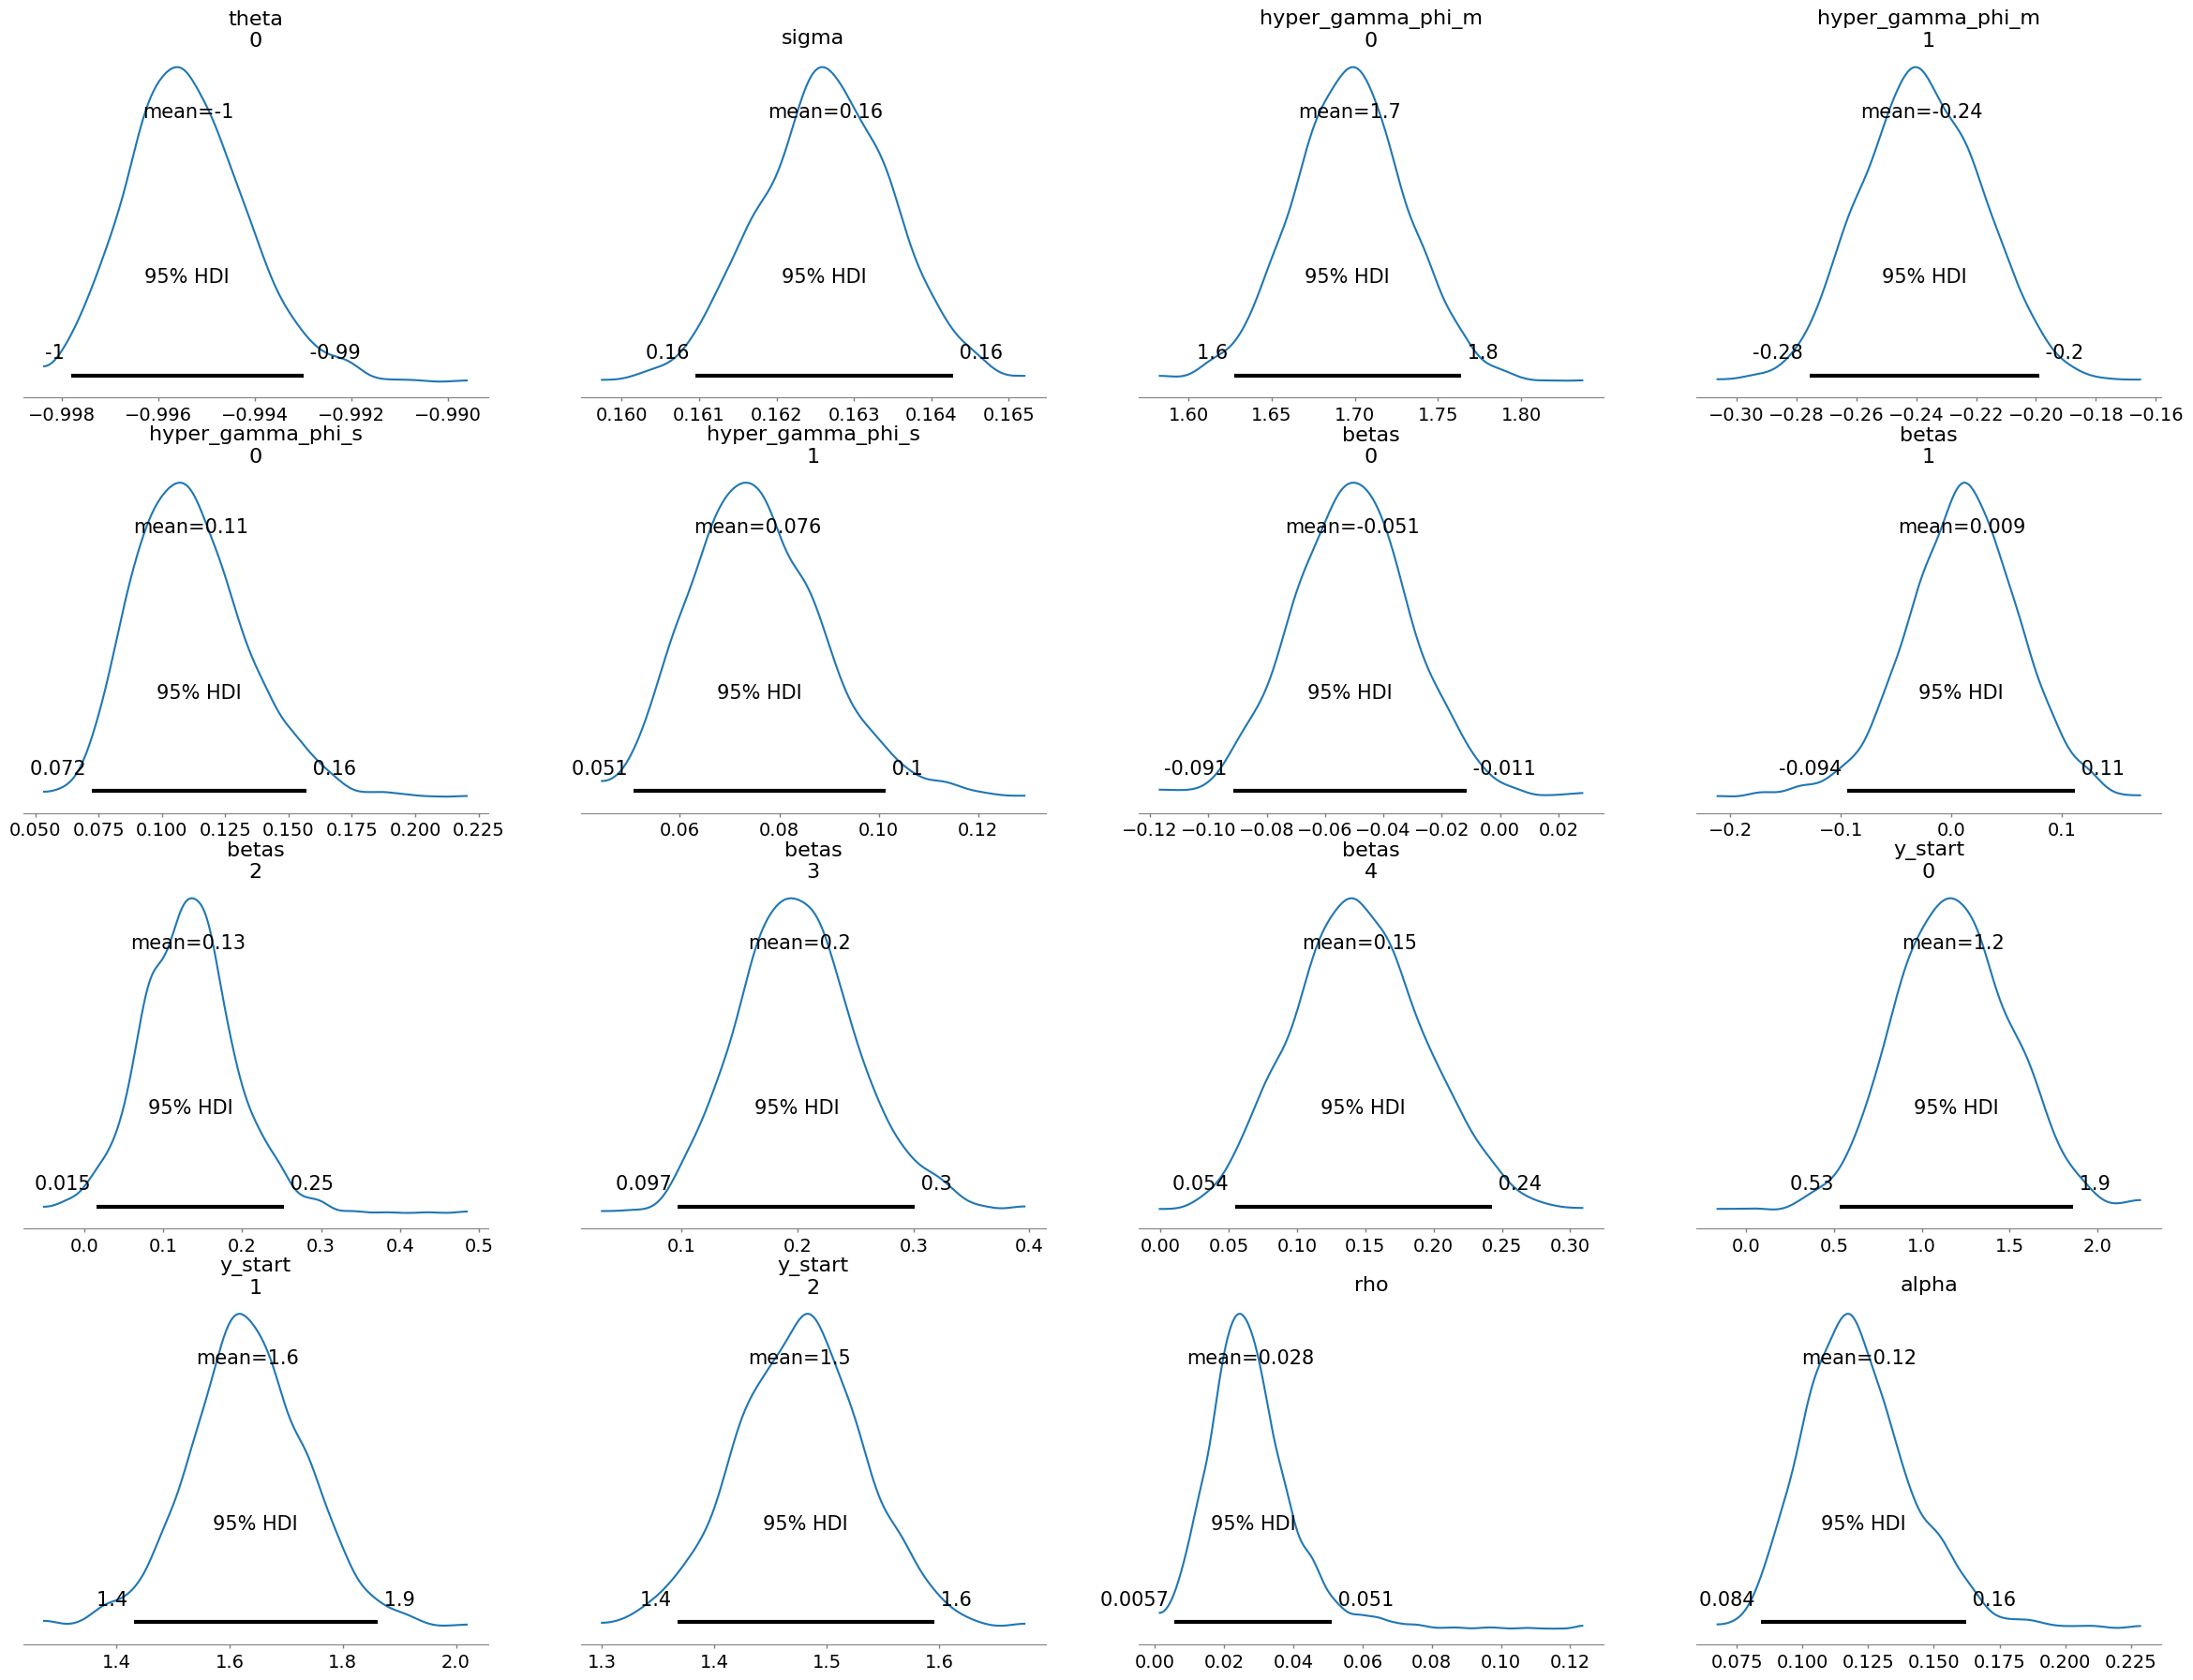

In [9]:
plt_aux = az.plot_posterior(ritorno['inference_data'], var_names=['theta','sigma', 'hyper_gamma_phi_m', 'hyper_gamma_phi_s','betas','y_start','rho','alpha'], hdi_prob=0.95)

<AxesSubplot: ylabel='Density'>

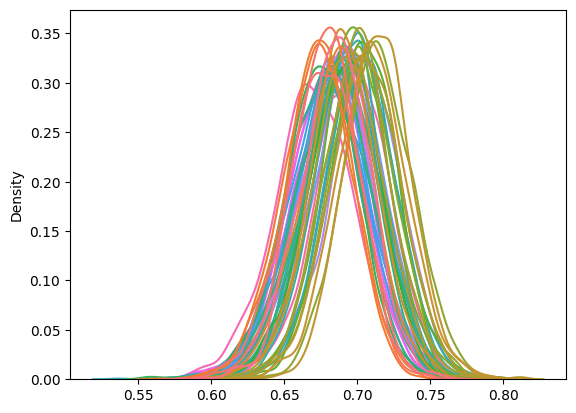

In [10]:
aux_shape = ritorno['inference_data'].posterior.phi.values.shape
sns.kdeplot(ritorno['inference_data'].posterior.phi.values.reshape((aux_shape[0]*aux_shape[1],aux_shape[2],aux_shape[3]))[:,0,:], legend=False)

<AxesSubplot: ylabel='Density'>

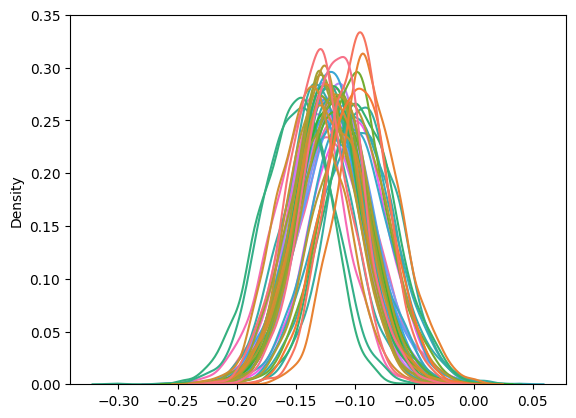

In [11]:
aux_shape = ritorno['inference_data'].posterior.phi.values.shape
sns.kdeplot(ritorno['inference_data'].posterior.phi.values.reshape((aux_shape[0]*aux_shape[1],aux_shape[2],aux_shape[3]))[:,1,:], legend=False)

<AxesSubplot: ylabel='Density'>

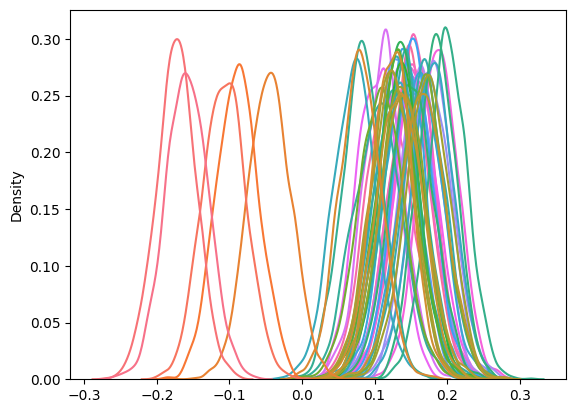

In [12]:
aux_shape = ritorno['inference_data'].posterior.c.values.shape
sns.kdeplot(ritorno['inference_data'].posterior.c.values.reshape((aux_shape[0]*aux_shape[1],aux_shape[2])), legend=False)

<AxesSubplot: ylabel='Density'>

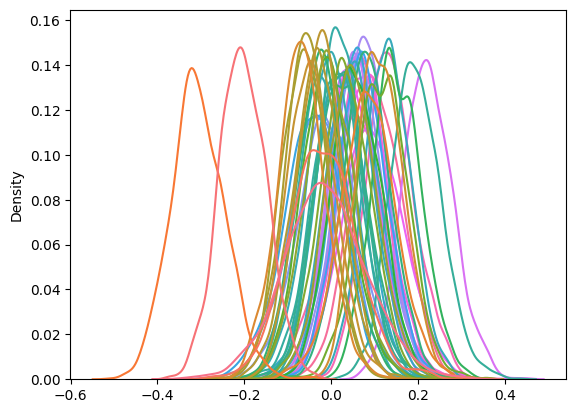

In [13]:
aux_shape = ritorno['inference_data'].posterior.w_s.values.shape
sns.kdeplot(ritorno['inference_data'].posterior.w_s.values.reshape((aux_shape[0]*aux_shape[1],aux_shape[2])), legend=False)

In [14]:
pd.set_option('display.max_columns', 500)
spatial_results = pd.DataFrame(ritorno['inference_data'].posterior.w_s.values.reshape((aux_shape[0]*aux_shape[1],aux_shape[2])), columns=df.columns).describe()
spatial_results.loc['abs_dist_from_mean',:] = (spatial_results.loc['mean',:] - spatial_results.loc['mean',:].mean()).abs()
spatial_results.sort_values('abs_dist_from_mean', axis=1, ascending=False)
#spatial_results.sort_values('mean', axis=1, ascending=True)

,SAVIGNANO DI RIGO,FEBBIO,S. ROCCO,BESENZONE,GAVELLO,SAN FRANCESCO,GHERARDI,VERUCCHIO,SAN PIETRO CAPOFIUME,DE AMICIS,MARECCHIA,BADIA,GIARDINI MARGHERITA,TIMAVO,BOGOLESE,MALCANTONE,PARCO BERTOZZI,PARADIGNA,SAN LEO,PARCO RESISTENZA,CASTELLARANO,ROMA,CORTE BRUGNATELLA,GIARDINI,ZALAMELLA,ISONZO,CASTELLUCCIO,MONTEBELLO,SARAGAT,CITTADELLA,SAN LAZZARO,CENO,REMESINA,FRANCHINI-ANGELONI,VILLA FULVIA,LUGAGNANO,CENTO,GERBIDO,GIORDANI-FARNESE,FLAMINIA,VIA CHIARINI,S. LAZZARO,CAORLE,PARCO FERRARI,DELTA CERVIA,PORTA SAN FELICE,PARCO MONTECUCCO,PARCO EDILCARANI,SAVIGNANO
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,-0.305698,-0.202728,0.223761,0.196973,0.152613,0.138075,0.130803,-0.066858,0.120222,-0.059214,-0.055680,0.114733,-0.047830,0.106055,-0.043047,0.097110,-0.031379,-0.027985,0.085753,-0.023464,0.082708,-0.021623,-0.018682,0.075727,-0.015368,0.075032,-0.013152,0.072785,0.072353,0.071794,-0.009966,-0.008656,0.064968,-0.004388,-0.002061,0.058375,0.056804,0.055808,0.053830,0.050837,0.048074,0.047279,0.015372,0.044803,0.018928,0.020083,0.022420,0.025389,0.034255
std,0.061977,0.053627,0.056977,0.057397,0.055401,0.056544,0.053161,0.055353,0.058172,0.054152,0.053555,0.053452,0.059341,0.061052,0.066281,0.071003,0.057088,0.069895,0.064578,0.052324,0.056390,0.057681,0.078087,0.058257,0.058625,0.052922,0.095740,0.058192,0.056461,0.056073,0.057328,0.068328,0.056665,0.057349,0.055757,0.056793,0.056104,0.069665,0.057406,0.059588,0.058873,0.055513,0.060482,0.057345,0.056890,0.051596,0.058153,0.059120,0.058021
min,-0.508420,-0.374933,0.058755,0.021714,-0.031498,-0.073206,-0.036397,-0.220960,-0.086778,-0.237838,-0.277047,-0.048703,-0.273921,-0.081929,-0.263886,-0.125923,-0.197711,-0.279839,-0.111809,-0.184927,-0.117959,-0.215187,-0.296111,-0.122459,-0.187081,-0.103554,-0.348997,-0.125446,-0.196092,-0.119531,-0.197613,-0.295307,-0.157696,-0.179932,-0.191648,-0.131176,-0.152857,-0.173330,-0.203730,-0.156051,-0.182175,-0.144027,-0.203378,-0.127598,-0.210903,-0.147154,-0.189917,-0.199475,-0.189040
25%,-0.346277,-0.240140,0.183392,0.158010,0.114492,0.100551,0.094095,-0.103446,0.080710,-0.097803,-0.090349,0.077837,-0.086763,0.065159,-0.086146,0.048524,-0.068405,-0.072933,0.043211,-0.059514,0.045535,-0.060458,-0.069075,0.033066,-0.055511,0.039867,-0.077641,0.034077,0.033863,0.034789,-0.049749,-0.052690,0.026401,-0.041510,-0.038616,0.018976,0.018608,0.009703,0.015025,0.010552,0.007396,0.011254,-0.025449,0.005486,-0.020097,-0.013520,-0.015863,-0.014635,-0.004997
50%,-0.309730,-0.204866,0.221936,0.194111,0.148506,0.135269,0.129963,-0.067802,0.120235,-0.060254,-0.056299,0.112710,-0.047624,0.103136,-0.040243,0.094079,-0.031308,-0.029033,0.085518,-0.022473,0.081473,-0.022706,-0.019769,0.075177,-0.017563,0.075684,-0.015897,0.071633,0.071216,0.070659,-0.010499,-0.009150,0.063324,-0.004881,-0.002056,0.055849,0.056468,0.056491,0.052187,0.047449,0.047068,0.047959,0.015366,0.045502,0.018293,0.017903,0.021997,0.023068,0.032657
75%,-0.264202,-0.165589,0.261335,0.234437,0.190104,0.173059,0.166793,-0.033185,0.158385,-0.022929,-0.020531,0.150008,-0.008828,0.147084,0.002637,0.144856,0.005868,0.017650,0.127376,0.010861,0.118751,0.014763,0.031047,0.113591,0.023502,0.109968,0.047149,0.110920,0.109623,0.108698,0.027247,0.037420,0.101679,0.035171,0.035516,0.097034,0.092907,0.101652,0.091272,0.090237,0.085901,0.083197,0.052480,0.080706,0.056406,0.054127,0.061022,0.063967,0.073714
max,-0.030481,-0.030157,0.452114,0.433790,0.328217,0.340326,

In [15]:
y_post_pred = ritorno['inference_data'].posterior.y_post_pred.to_numpy()
y_post_pred = y_post_pred.reshape(y_post_pred.shape[0]*y_post_pred.shape[1], y_post_pred.shape[2], y_post_pred.shape[3])
y_post_pred.shape

(2000, 365, 49)

In [16]:
import ipywidgets as widgets
from ipywidgets import HBox, VBox
from IPython.display import display

In [17]:
@widgets.interact(stazione = df.columns)
def f(stazione):
    col_map = sns.light_palette((20, 75, 70), input='husl', as_cmap=True)

    plt.figure(figsize=(14,8))
    ax = plt.subplot(1,1,1)

    idx_stazione = df.columns.to_list().index(stazione)
    
    """
    sns.lineplot(np.transpose(y_post_pred[0:50,:,idx_stazione]))
    """

    lower_lim = np.zeros(len(df.index))
    upper_lim = np.zeros(len(df.index))    
    for i in range(len(df.index)):
        lower_lim[i] = np.percentile(y_post_pred[:,i,idx_stazione],2.5)
        upper_lim[i] = np.percentile(y_post_pred[:,i,idx_stazione],97.5)
    
    
#    sns.lineplot(lower_lim)
#    sns.lineplot(upper_lim)
    
    for i in range(len(df.index)):
        ax.add_patch(mplt.patches.Rectangle((i,lower_lim[i]),1,upper_lim[i]-lower_lim[i], fill=True, color=col_map(180)))

    sns.lineplot(df[stazione])    
    sns.lineplot(np.mean(y_post_pred[:,:,idx_stazione], axis=0))


    index = 0
    for line in ax.get_lines():
        if index == 0:
            col_map = sns.dark_palette((230,90,65), input='husl', as_cmap=True)
            line.set_c(col_map(155))
        else:
            col_map = sns.dark_palette((10,90,65), input='husl', as_cmap=True)
            line.set_c(col_map(175))
        index += 1
        
    plt.ylim(bottom=0,top=2.5)

    primo_giorno = datetime.date(2018,1,1)
    date_da_segnare = []
    date_da_segnare_posizioni = []

    for i in range(12):
        date_da_segnare.append(datetime.date(2018,i+1,1))
        date_da_segnare_posizioni.append((date_da_segnare[2*i] - primo_giorno).days)
        date_da_segnare.append(datetime.date(2018,i+1,15))
        date_da_segnare_posizioni.append((date_da_segnare[2*i+1] - primo_giorno).days)
        date_da_segnare[2*i] = date_da_segnare[2*i].isoformat()
        date_da_segnare[2*i+1] = date_da_segnare[2*i+1].isoformat()

    plt.xticks(date_da_segnare_posizioni,date_da_segnare,rotation=65)
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=True,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=True)
    plt.grid()
    
    """
    ax.get_legend().remove()
    col_vals = np.linspace(1,255,num=len(df.columns))
    index = 0
    for line in ax.get_lines():
        if(index == len(ax.get_lines()) - 1):
            col_map = sns.dark_palette((230,90,65), input='husl', as_cmap=True)
            line.set_c(col_map(175))
            continue
        if(index == len(ax.get_lines()) - 2):
            col_map = sns.dark_palette((120,90,65), input='husl', as_cmap=True)
            line.set_c(col_map(175))
            index += 1
            continue

        #line.set_c(col_map(int(np.round(col_vals[index]))))
        line.set_c(col_map(220))
        line.set_alpha(0.3)
        index += 1
    """
    
    

    plt.show()

interactive(children=(Dropdown(description='stazione', options=('CASTELLUCCIO', 'FEBBIO', 'CORTE BRUGNATELLA',…

In [18]:
def f(stazione):
    col_map = sns.light_palette((20, 75, 70), input='husl', as_cmap=True)

    plt.figure(figsize=(14,8))
    ax = plt.subplot(1,1,1)

    idx_stazione = df.columns.to_list().index(stazione)
    
    """
    sns.lineplot(np.transpose(y_post_pred[0:50,:,idx_stazione]))
    """

    lower_lim = np.zeros(len(df.index))
    upper_lim = np.zeros(len(df.index))    
    for i in range(len(df.index)):
        lower_lim[i] = np.percentile(y_post_pred[:,i,idx_stazione],2.5)
        upper_lim[i] = np.percentile(y_post_pred[:,i,idx_stazione],97.5)
    
    
#    sns.lineplot(lower_lim)
#    sns.lineplot(upper_lim)
    
    for i in range(len(df.index)):
        ax.add_patch(mplt.patches.Rectangle((i,lower_lim[i]),1,upper_lim[i]-lower_lim[i], fill=True, color=col_map(180)))

    sns.lineplot(df[stazione])    
    sns.lineplot(np.mean(y_post_pred[:,:,idx_stazione], axis=0))


    index = 0
    for line in ax.get_lines():
        if index == 0:
            col_map = sns.dark_palette((230,90,65), input='husl', as_cmap=True)
            line.set_c(col_map(155))
        else:
            col_map = sns.dark_palette((10,90,65), input='husl', as_cmap=True)
            line.set_c(col_map(175))
        index += 1
        
    plt.ylim(bottom=0,top=2.5)

    primo_giorno = datetime.date(2018,1,1)
    date_da_segnare = []
    date_da_segnare_posizioni = []

    for i in range(12):
        date_da_segnare.append(datetime.date(2018,i+1,1))
        date_da_segnare_posizioni.append((date_da_segnare[2*i] - primo_giorno).days)
        date_da_segnare.append(datetime.date(2018,i+1,15))
        date_da_segnare_posizioni.append((date_da_segnare[2*i+1] - primo_giorno).days)
        date_da_segnare[2*i] = date_da_segnare[2*i].isoformat()
        date_da_segnare[2*i+1] = date_da_segnare[2*i+1].isoformat()

    plt.xticks(date_da_segnare_posizioni,date_da_segnare,rotation=65)
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=True,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=True)
    plt.grid()
    
    """
    ax.get_legend().remove()
    col_vals = np.linspace(1,255,num=len(df.columns))
    index = 0
    for line in ax.get_lines():
        if(index == len(ax.get_lines()) - 1):
            col_map = sns.dark_palette((230,90,65), input='husl', as_cmap=True)
            line.set_c(col_map(175))
            continue
        if(index == len(ax.get_lines()) - 2):
            col_map = sns.dark_palette((120,90,65), input='husl', as_cmap=True)
            line.set_c(col_map(175))
            index += 1
            continue

        #line.set_c(col_map(int(np.round(col_vals[index]))))
        line.set_c(col_map(220))
        line.set_alpha(0.3)
        index += 1
    """
    
    

    plt.show()

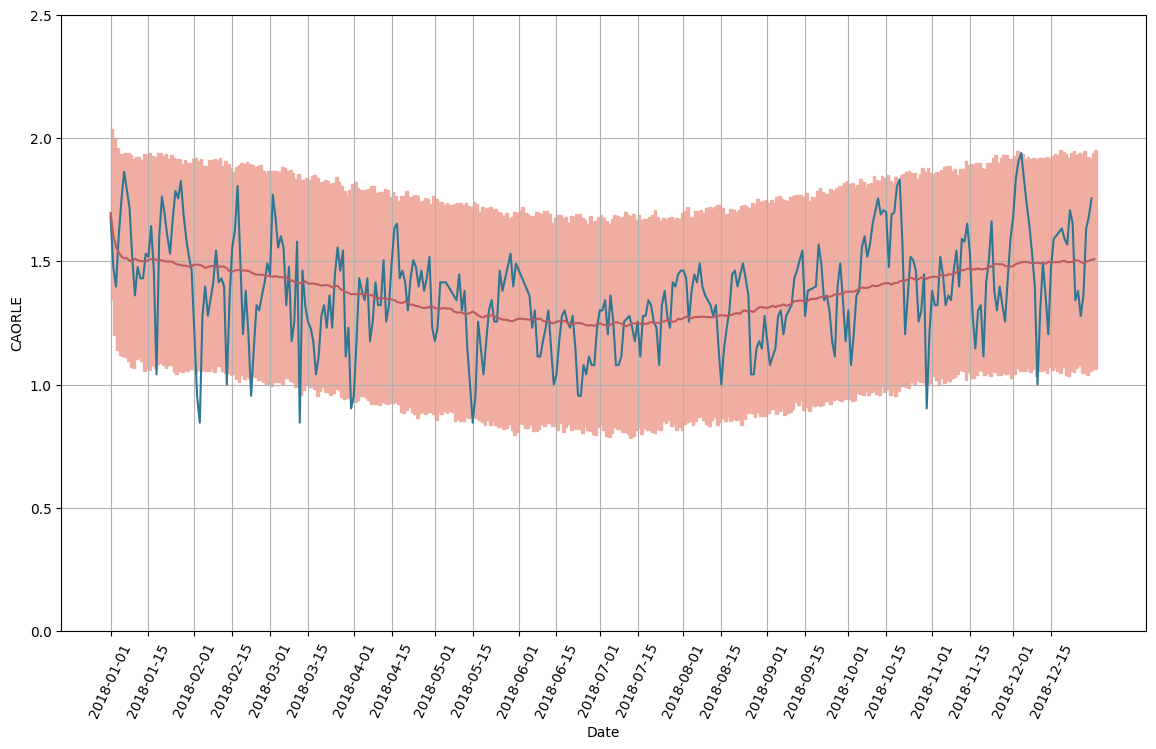

In [19]:
f('CAORLE')

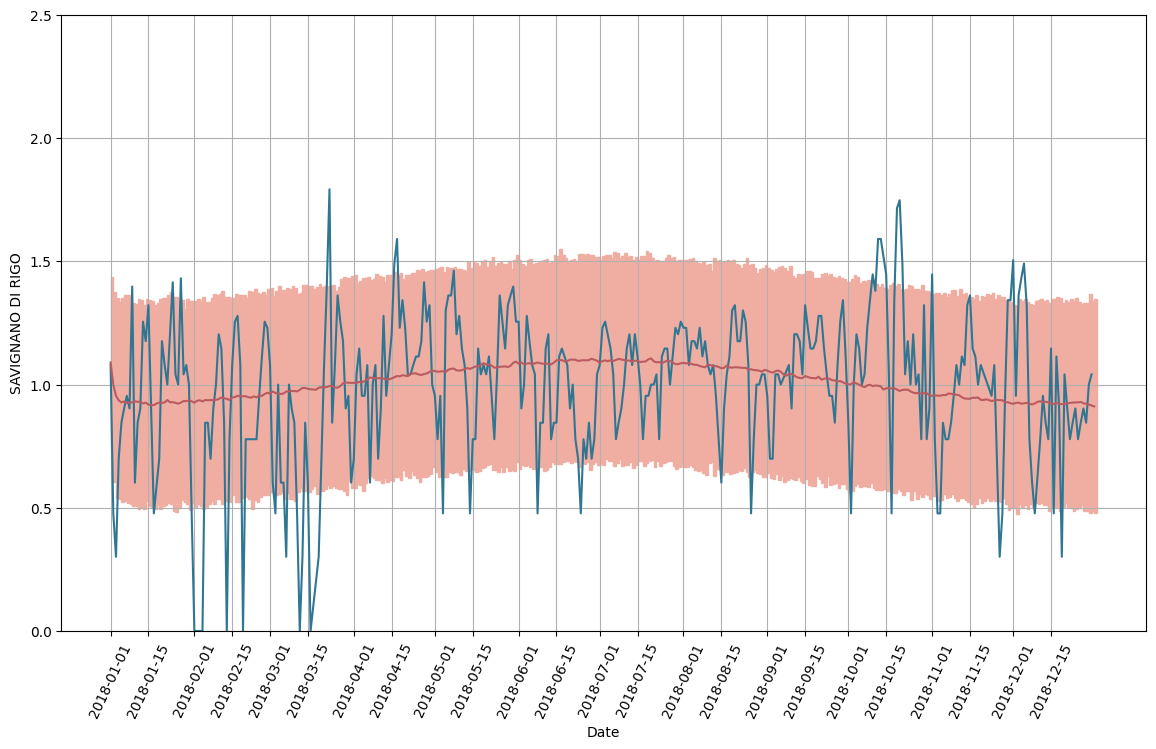

In [20]:
f('SAVIGNANO DI RIGO')